In [1]:
from numpy import *
import matplotlib.pyplot as plt

# <center>Partie pratique : Sujet 2</center>
# <center>Équation de Burgers visqueuse</center>

On considère le problème :
$$
\begin{array}{cl}
\frac{\partial u}{\partial t}-\nu\frac{\partial^{2} u}{\partial x^{2}}+u\frac{\partial u}{\partial x}=0 & \text {dans }(0, 1) \times(0,T), \\
\frac{\partial u}{\partial x}(0, t)=0, \text { et } ~\frac{\partial u}{\partial x}(1, t)=0 & \text {pour } ~ t \geq 0, \\
u(x, 0)=u_{0}(x) & \text {dans }(0,1),
\end{array}
$$

À faire : Mettre en oeuvre un schéma numérique pour résoudre cette équation, en traitant les termes linéaires de manière implicite, et le terme non linéaire de manière explicite. Rechercher des conditions initiales et des valeurs de $\nu>0$ pour lesquelles l'énergie de la solution va croítre en temps.

Schéma explicite : $u^{n+1}$ calculé à partir de $u^n$ de manière explicite (sans résoudre de système)

Schéma implicite : $u^{n+1}$ calculé en résolvant un système du type $Au^{n+1} = u^n$

### Méthode pour l'exo4 du tp1 : à adapter $(\frac{\partial u}{\partial t}-\nu\frac{\partial^{2} u}{\partial x^{2}} = 0)$

Pour résoudre l'équation, on pose $$\frac{\partial u}{\partial t} \sim \frac{u^{n+1} - u^n}{\Delta t}.$$
On a alors $$\int^1_0 (u^{n+1}-u^n)v + \Delta t \int^1_0 (u^{n+1})'v' = 0$$
ce qui nous donne $$\int^1_0 u^{n+1}v + \Delta t \int^1_0 (u^{n+1})'v' = \int^1_0 u^nv.$$
Avec $u^{n+1}(x) = \sum_i u_i^{n+1} \phi_i(x)$
et $v(x) = \phi_j(x)$, on a $\forall j$ 

$f(u^n)'(x) = \sum_i u_i^{n} (f(\phi_i(x)))'$:

$$ \sum_i u_i^{n+1} \left( \int^1_0 \phi_i \phi_j + \Delta t \int^1_0 \phi_i' \phi_j' \right) = \sum_i u_i^{n} \left( \int^1_0 \phi_i \phi_j - \frac{\Delta t}{2} \int^1_0 f(\phi_i)' \phi_j \right)$$

Il manque le $\nu$ à mettre quelque part

In [2]:
nx=int(input("Nombre d'intervalles de la subdivision :\n"))

# Création du maillage
Pt = linspace(0,1,nx+1)

# Création du tableau de correspondance
seg = zeros((nx,2),dtype=int)  #tableau de taille nx, et 2 noeuds par éléments
seg[:,0] = arange(nx)          #arange = intervalle de 0 à nx       
seg[:,1] = arange(nx)+1

# Coefficient de viscosité
nu = 1.;

Nombre d'intervalles de la subdivision :
100


### Lecture du maillage

In [3]:
# Coordonnées des noeuds du maillage
X = Pt[:]
# Nombre de noeuds
Nb_Noeuds = size(X)
# Nombre de segments
Nb_ele = shape(seg)[0]

### Calcul de la matrice de rigidité

Pour calculer la matrice de rigidité, on calcule deux matrices distinctes : la matrice $M_{ij}$ qui représente $\int^1_0 \phi_i \phi_j$ et la matrice $S_{ij}$ qui représente $\int^1_0 \phi_i' \phi_j'$.

**En gros, ici il va falloir rajouter une troisième matrice pour le troisième terme de l'équation je pense $(u\frac{\partial u}{\partial x})$. Après à voir ce que signifie de manière explicite aussi.**

In [9]:
# Initialisation de la matrice de rigidité
S = zeros((Nb_Noeuds,Nb_Noeuds));
Selt = zeros((2,2));
M = zeros((Nb_Noeuds,Nb_Noeuds));
Melt = zeros((2,2));
A = zeros((Nb_Noeuds,Nb_Noeuds));
Aelt = zeros((2,2));

# Boucle sur les éléments
for j in range(Nb_ele):

    # Numéros globaux des extrémités du segment
    i1 = seg[j,0]    
    i2 = seg[j,1]
    I = [i1, i2]
    
    # Coordonnées des deux extrémités
    X1 = X[i1] 
    X2 = X[i2]

    # Calcul de la longueur de l'élément
    l = abs(X2-X1)
 
    # Calcul de la matrice élémentaire       
    Selt[0,0] = 1   
    Selt[0,1] = -1   
    Selt[1,0] = -1   
    Selt[1,1] = 1
    
    Melt[0,0] = 1/3   
    Melt[0,1] = 1/6  
    Melt[1,0] = 1/6  
    Melt[1,1] = 1/3

    ###
    coef  = nu/l
    Selt *= coef
    Melt *= l
    
    Aelt = 2/l**2 * Melt

    # Assemblage des matrices élémentaires
    S[ix_(I,I)] += Selt
    M[ix_(I,I)] += Melt
    A[ix_(I,I)] += Aelt

# Fin de boucle sur les éléments

### Résolution de système : Inversion de matrice avec $u_0(x)=\sin(\pi x)$ 

On résout donc l'équation $$(M + \Delta t S) U^{n+1} = (M - \frac{\Delta t}{2} A) U^n.$$ 

In [19]:
def u_0(X):
    for i in range(len(X)):
        if X[i]<0:
            X[i]=1
        elif X[i]>=0 and X[i]<1 :
            X[i]=1-X[i]
        else:
            X[i]=0
    return X

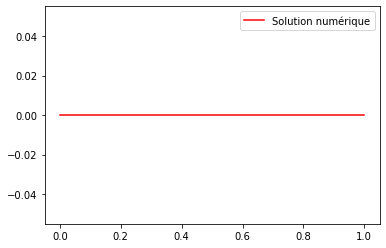

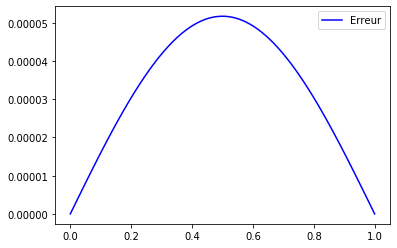

Erreur L2 : 3.6573815709290184e-05
Erreur relative : inf


/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


In [20]:
u0_0 = lambda x: sin(pi*x)
        
n=10000
T = 1
dT = T/n
        
U = u_0(X)
for i in range(n) :
    U = linalg.solve(M+dT*S,dot(M-dT/2*A,U))

#solution exacte calculée à la main

exact = lambda x: u0_0(x)*exp(-(pi**2)*T)
V =  exact(X)
Err = V - U


### Affichage solution
xx = linspace(0,1,500)
#plt.plot(xx,exact(xx),'g',label='Solution exacte')
plt.plot(X,U,'r',label='Solution numérique')
plt.legend(loc='best')
plt.show()

plt.plot(X,Err,'b',label='Erreur')
plt.legend(loc='best')
plt.show()

# L2 erreur
ErrL2 = sqrt(sum(Err**2)/nx)
print("Erreur L2 :", ErrL2)

# Erreur relative par rapport à la solution théorique
ErrRel = sqrt(sum(Err*Err)/sum(U*U))
print('Erreur relative :', ErrRel)

Solution exacte :

$$
u_{\kappa}(t, x)=\frac{\int_{\mathbb{R}} \frac{x-y}{t} e^{-\frac{F(t, x, y)}{2 \kappa}} d y}{\int_{\mathbb{R}} e^{-\frac{F(t, x, y)}{2 \kappa}} d y}
$$
en définissant $F$ par
$$
F(t, x, y)=\frac{(x-y)^{2}}{2 t}+\int_{0}^{y} u^{0}(z) d z
$$